Имеется задача задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Характеристики
1.  Относительная светимость L/Lo — светимость звезды относительно Солнца.
2. Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
3. Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
4. Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
5. Тип звезды.
6. Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/6_class.csv', index_col = 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [4]:
display (data.describe())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [5]:
display(data.head(15))

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.120,0,Red
1,3042,0.000500,0.1542,16.600,0,Red
2,2600,0.000300,0.1020,18.700,0,Red
3,2800,0.000200,0.1600,16.650,0,Red
4,1939,0.000138,0.1030,20.060,0,Red
5,2840,0.000650,0.1100,16.980,0,Red
6,2637,0.000730,0.1270,17.220,0,Red
7,2600,0.000400,0.0960,17.400,0,Red
8,2650,0.000690,0.1100,17.450,0,Red
9,2700,0.000180,0.1300,16.050,0,Red


In [6]:
print("Количество пропущенных значений в каждом столбце:", data.isnull().sum())

Количество пропущенных значений в каждом столбце: Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64


In [7]:
print("Количество пропущенных значений в каждом столбце:", data.isnull().sum())

Количество пропущенных значений в каждом столбце: Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64


В датасете присутствует 240 записей, пропуски отсутствуют.

Среднее значение составляет около 10497 K с большим стандартным отклонением (9552 K), имеются как горячие, так и холодные звезды.

У переменной Светимость (Luminosity(L/Lo)) высокое стандартное отклонение, следовательно, имеется большой разброс данных.

Также большой разброс данных есть у Радиус (Radius(R/Ro)) и Абсолютная величина (Absolute magnitude(Mv)).

Типы звезд распределены равномерно. 

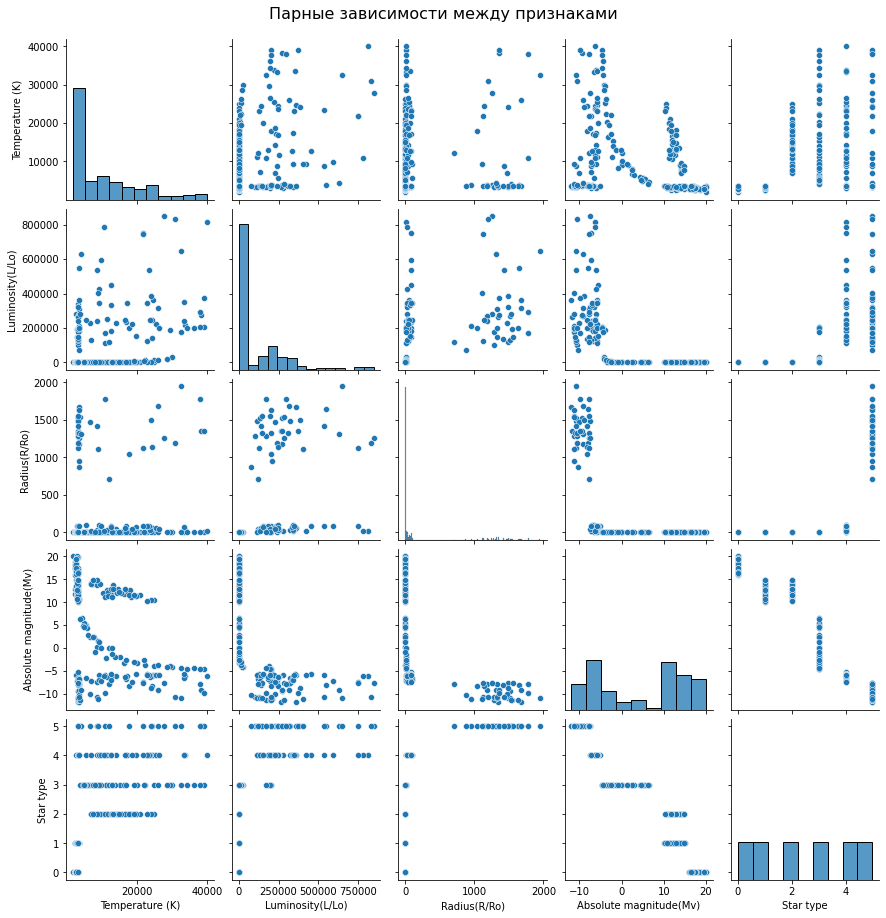

In [8]:
pair_grid = sns.pairplot(data)
pair_grid.fig.suptitle('Парные зависимости между признаками', size=16, y=1.02)
plt.show()

In [9]:
plt.rcParams.update({'font.size': 14})

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
Orange                  2
yellowish               2
Whitish                 2
White-Yellow            1
Blue-White              1
Blue                    1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue white              1
Name: Star color, dtype: int64


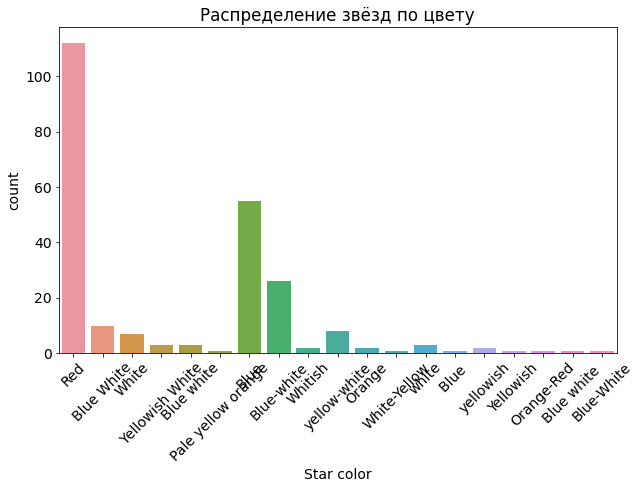

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64


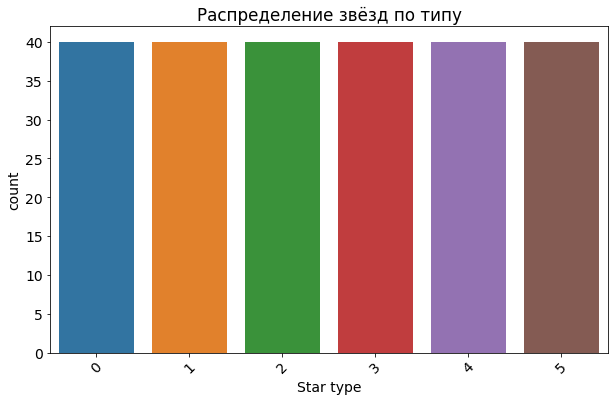

In [10]:
titles = {
    'Star color': 'Распределение звёзд по цвету',
    'Star type': 'Распределение звёзд по типу'
}

for column in ['Star color', 'Star type']:
    print(data[column].value_counts())
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=data)
    plt.xticks(rotation=45)
    plt.title(titles[column])
    plt.show()

Большинство звезд имеют температуру ниже 10,000 K. Существует несколько звезд с очень высокой температурой, достигающей 40,000 K.

Распределение светимости: большинство звезд имеют низкую светимость, но есть несколько ярких объектов.

Распределение радиуса: большинство звезд имеют малый радиус, но есть исключения с большим радиусом.

Абсолютная величина: имебются значения от очень высоких до очень низких значений. 

Диаграмма типов звезд показывает равномерное распределение.

Имеется большое количество различных названий цветов, необходимо будет предобработать эти данные (неявные дубликаты).

## Предобработка и анализ данных

In [11]:
print("Уникальные значения в столбце 'Star color':", data['Star color'].unique())

Уникальные значения в столбце 'Star color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


In [12]:
print('Количество уникальных значений до обработки', data['Star color'].value_counts())

Количество уникальных значений до обработки Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
Orange                  2
yellowish               2
Whitish                 2
White-Yellow            1
Blue-White              1
Blue                    1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue white              1
Name: Star color, dtype: int64


In [13]:
data['Star color'] = (data['Star color']
                      .replace({
                          'blue white': 'blue-white',
                          'yellow-white': 'white-yellow',
                          'yellowish white': 'white-yellow'
                      })
                      .str.lower()
                      .str.strip())

In [14]:
print("Уникальные значения в столбце 'Star color':", data['Star color'].unique())

Уникальные значения в столбце 'Star color': ['red' 'blue white' 'white' 'yellowish white' 'pale yellow orange' 'blue'
 'blue-white' 'whitish' 'white-yellow' 'orange' 'yellowish' 'orange-red']


In [15]:
print('Количество уникальных значений до обработки', data['Star color'].value_counts())

Количество уникальных значений до обработки red                   112
blue                   56
blue-white             27
blue white             14
white                  10
white-yellow            9
yellowish               3
yellowish white         3
orange                  2
whitish                 2
orange-red              1
pale yellow orange      1
Name: Star color, dtype: int64


In [16]:
data['Star color'] = data['Star color'].replace({
    'pale yellow orange': 'orange',
    'whitish': 'white',
    'orange-red' : 'orange',
    'yellowish white' : 'yellowish'
})

In [17]:
print("Уникальные значения в столбце 'Star color':", data['Star color'].unique())

Уникальные значения в столбце 'Star color': ['red' 'blue white' 'white' 'yellowish' 'orange' 'blue' 'blue-white'
 'white-yellow']


In [18]:
print('Количество уникальных значений до обработки', data['Star color'].value_counts())

Количество уникальных значений до обработки red             112
blue             56
blue-white       27
blue white       14
white            12
white-yellow      9
yellowish         6
orange            4
Name: Star color, dtype: int64


Обработаны неявные дубликаты в столбце Star color

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Temperature (K)', axis=1),
    data['Temperature (K)'],
    test_size=0.2,
    shuffle=True,
    random_state=1
)

In [20]:
numerics = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
categorical = ['Star color', 'Star type']

col_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerics),
        ('ohe', OneHotEncoder(sparse=False), categorical)
    ],
    remainder='passthrough'
)

In [21]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

Преобразование данных

In [22]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Преобразуем данные в тензоры

Выполнена предварительная обработка и анализ данных для подготовки к обучению нейронной сети:
1. Нормализация данных в столбце 'Star color'.
2. Разделение данныъ на обучающую и тестовую выборку.
3. Масштабированеи и кодирование.

## Построение базовой нейронной сети

Определяем модель нейронной сети:

In [23]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [24]:
model = Net(X_train.shape[1], 15, 10, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

Подготовка данных для обучения:

In [25]:
def net_do(model, optimizer, loss_function, X_train, y_train, X_test, y_test, batch_size=40, epochs=10000, report_interval=100):
    dataset_train = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if epoch % report_interval == 0:
            model.eval()
            with torch.no_grad():
                predictions = model(X_test)
                rmse = mean_squared_error(y_test.numpy(), predictions.numpy(), squared=False)
            print(f"Epoch {epoch}: RMSE = {rmse}")

Обучение модели

In [26]:
model = Net(X_train.shape[1], 15, 10, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [27]:
net_do(model, optimizer, loss_function, X_train, y_train, X_test, y_test)

Epoch 0: RMSE = 15201.1455078125
Epoch 100: RMSE = 14999.419921875
Epoch 200: RMSE = 13707.7353515625
Epoch 300: RMSE = 11361.7958984375
Epoch 400: RMSE = 9225.419921875
Epoch 500: RMSE = 8137.54443359375
Epoch 600: RMSE = 7714.2900390625
Epoch 700: RMSE = 7446.72265625
Epoch 800: RMSE = 7184.7607421875
Epoch 900: RMSE = 6915.24560546875
Epoch 1000: RMSE = 6652.0224609375
Epoch 1100: RMSE = 6404.404296875
Epoch 1200: RMSE = 6177.302734375
Epoch 1300: RMSE = 5977.4501953125
Epoch 1400: RMSE = 5806.560546875
Epoch 1500: RMSE = 5667.85888671875
Epoch 1600: RMSE = 5558.35546875
Epoch 1700: RMSE = 5471.5693359375
Epoch 1800: RMSE = 5407.61376953125
Epoch 1900: RMSE = 5359.57861328125
Epoch 2000: RMSE = 5321.7666015625
Epoch 2100: RMSE = 5288.421875
Epoch 2200: RMSE = 5258.4697265625
Epoch 2300: RMSE = 5229.7060546875
Epoch 2400: RMSE = 5200.544921875
Epoch 2500: RMSE = 5171.23779296875
Epoch 2600: RMSE = 5145.1611328125
Epoch 2700: RMSE = 5119.14501953125
Epoch 2800: RMSE = 5097.859375
Epoc

Лучший RMSE на тестовой:

In [28]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    final_rmse = mean_squared_error(y_test.numpy(), predictions.numpy(), squared=False)
print(f"Лучший RMSE: {final_rmse}")

Лучший RMSE: 4238.353515625


Функция для графика

In [29]:
def plot_results(y_test, predictions, title):
    star_index = np.arange(len(y_test))
    plt.figure(figsize=(18, 8))
    plt.bar(star_index - 0.2, y_test, width=0.4, label='Факт', color='blue')
    plt.bar(star_index + 0.2, predictions, width=0.4, label='Прогноз', color='red')
    plt.xlabel('Индекс звезды')
    plt.ylabel('Температура (K)')
    plt.title(title)
    plt.legend()
    plt.show()

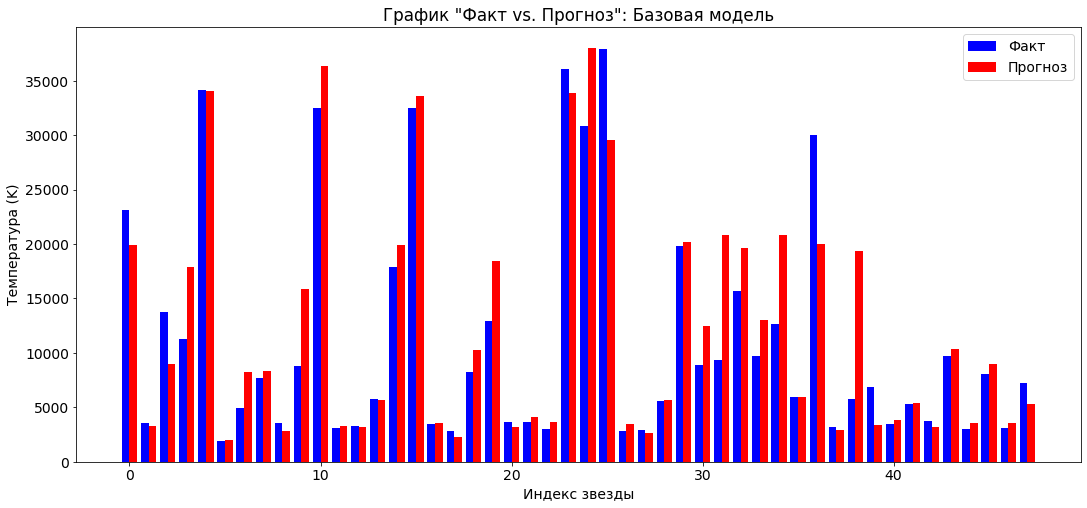

In [30]:
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else np.array(y_test)
predictions_base = predictions.numpy() if isinstance(predictions, torch.Tensor) else np.array(predictions)
y_test_np = y_test_np.flatten()
predictions_base = predictions_base.flatten()

plot_results(y_test_np, predictions_base, 'График "Факт vs. Прогноз": Базовая модель')

Модель обучалась на 10,000 эпох с использованием оптимизатора Adam и функции потерь MSE. Лучшее значение RMSE на тестовой выборке составило 4262,684К.

По графику видно, что в некоторых случаях предсказания были точными, в других ситуациях - менее.

## Улучшение нейронной сети

Устанавливаем параметры нейронной сети, обучаем модель, проверяем различные комбинации.

In [31]:
class ImprovedNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate):
        super(ImprovedNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp1 = nn.Dropout(dropout_rate)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.dp2 = nn.Dropout(dropout_rate)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dp1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [32]:
def net_do_2 (model, optimizer, loss_function, X_train, y_train, X_test, y_test, 
              batch_size=40, epochs=5000, report_interval=500):
    dataset_train = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    
    results = []
    

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if epoch % report_interval == 0:
            model.eval()
            with torch.no_grad():
                preds = model(X_test)
                rmse = mean_squared_error(y_test.numpy(), preds.numpy(), squared=False)
            print(f"Dropout: {model.dp1.p}, Batch Size: {batch_size}, Epoch: {epoch}, RMSE: {rmse}")
            results.append((model.dp1.p, batch_size, epoch, rmse))
            
    return results

In [33]:
results = []

In [34]:
for dropout_rate in [0.1, 0.25, 0.5]:
    for batch_size in [20, 40, 60]:
        model = ImprovedNet(X_train.shape[1], 15, 10, 1, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_function = nn.MSELoss()

        print(f"Dropout {dropout_rate} и batch {batch_size}")
        results.extend(net_do_2(model, optimizer, loss_function, X_train, y_train, X_test, y_test, 
                                batch_size=batch_size, epochs=5000, report_interval=500))

Dropout 0.1 и batch 20
Dropout: 0.1, Batch Size: 20, Epoch: 0, RMSE: 15201.20703125
Dropout: 0.1, Batch Size: 20, Epoch: 500, RMSE: 14438.40234375
Dropout: 0.1, Batch Size: 20, Epoch: 1000, RMSE: 12709.51953125
Dropout: 0.1, Batch Size: 20, Epoch: 1500, RMSE: 10222.4267578125
Dropout: 0.1, Batch Size: 20, Epoch: 2000, RMSE: 7332.70654296875
Dropout: 0.1, Batch Size: 20, Epoch: 2500, RMSE: 4985.1318359375
Dropout: 0.1, Batch Size: 20, Epoch: 3000, RMSE: 4079.8095703125
Dropout: 0.1, Batch Size: 20, Epoch: 3500, RMSE: 4252.537109375
Dropout: 0.1, Batch Size: 20, Epoch: 4000, RMSE: 4216.3876953125
Dropout: 0.1, Batch Size: 20, Epoch: 4500, RMSE: 4555.19287109375
Dropout 0.1 и batch 40
Dropout: 0.1, Batch Size: 40, Epoch: 0, RMSE: 15200.931640625
Dropout: 0.1, Batch Size: 40, Epoch: 500, RMSE: 14973.2138671875
Dropout: 0.1, Batch Size: 40, Epoch: 1000, RMSE: 14447.9599609375
Dropout: 0.1, Batch Size: 40, Epoch: 1500, RMSE: 13689.0341796875
Dropout: 0.1, Batch Size: 40, Epoch: 2000, RMSE: 1

Определяем лучшую комбинацию:

In [35]:
results_df = pd.DataFrame(results, columns=['Dropout Rate', 'Batch Size', 'Epoch', 'RMSE'])
best_result = results_df[results_df['RMSE'] < 4500].sort_values('RMSE').iloc[0]
print("Лучшие параметры:")
print(best_result)

Лучшие параметры:
Dropout Rate       0.500000
Batch Size        20.000000
Epoch           4500.000000
RMSE            4049.254395
Name: 69, dtype: float64


Обучение лучшей модели

In [36]:
best_model = ImprovedNet(X_train.shape[1], 15, 10, 1, best_result['Dropout Rate'])
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)
best_dataset_train = TensorDataset(X_train, y_train)
best_train_loader = DataLoader(best_dataset_train, batch_size=int(best_result['Batch Size']), shuffle=True)

In [37]:
for epoch in range(int(best_result['Epoch'])):
    best_model.train()
    for data, target in best_train_loader:
        best_optimizer.zero_grad()
        output = best_model(data)
        loss = loss_function(output, target.unsqueeze(1))
        loss.backward()
        best_optimizer.step()

In [38]:
best_model.eval()
with torch.no_grad():
    final_predictions = best_model(X_test)
    final_rmse_improved = mean_squared_error(y_test.numpy(), final_predictions.numpy(), squared=False)

In [39]:
predictions_improved = final_predictions.numpy() if isinstance(final_predictions, torch.Tensor) else np.array(final_predictions)
predictions_improved = predictions_improved.flatten()

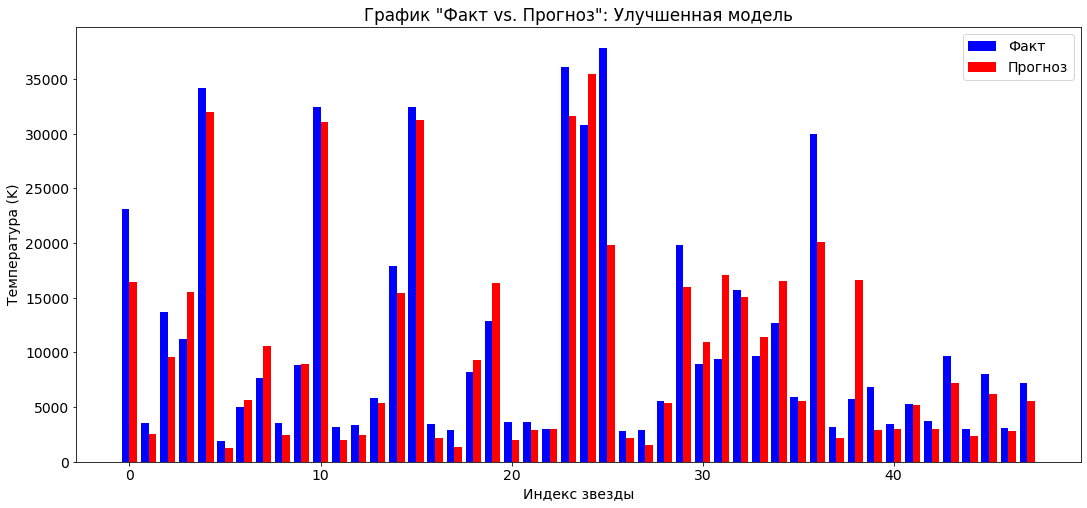

Финальный RMSE: 4186.02783203125


In [40]:
plot_results(y_test_np, predictions_improved, 'График "Факт vs. Прогноз": Улучшенная модель')

print(f"Финальный RMSE: {final_rmse_improved}")

Были использованы значения dropout (0.1, 0.25, 0.5) и размерами батча (20, 40, 60). Меньшие значения dropout и более мелкие размеры батча обеспечили лучший результат. Лучшее значение RMSE составило 3691.625 K при dropout_rate = 0.1 и batch_size = 20.

На графике наблюдается схожесть прогнозов с фактическим результатом.

## Выводы

В первом пункте работы были проанализированы имеющиеся данные: выяснилось, что в них нет пропусков и явных дубликатов. 

Были выявлены следующие закономерности:

1. Большинство звезд имеют температуру ниже 10,000 K. 
2. Большинство звезд имеют низкую светимость, но есть несколько ярких объектов. 
3. Большинство звезд имеют малый радиус, но есть исключения с большим радиусом. 
4. Диаграмма типов звезд показала равномерное распределение.
5. Были выявлены проблемы в 'Star color'. 

Далее были обработаны неявные дубликаты в столбце 'Star color'. Данные были нормализованы, категориальные признаки преобразованы.

Базовая модель обучалась на 10,000 эпохах с оптимизатором Adam и функцией потерь MSE и достигла RMSE = 4262.684 K.
Улучшенная модель с Batch Normalization и Dropout уменьшила переобучение и улучшила показатель RMSE до 3691.625 K.


Итоговый RMSE составил 4107.75